## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import seaborn as sns

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

In [3]:
df_ONO_train = pd.read_csv("../tables/data/ONO_train_set.csv").set_index('SMILES')
df_ONO_test = pd.read_csv("../tables/data/ONO_test_set.csv").set_index('SMILES')

### Useful fonctions

In [6]:
def evaluate_model(model, X,Y):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),('selector', VarianceThreshold()), ('m',model)])
    cv = RepeatedKFold(n_splits=10, n_repeats=10)# randomstate pas fixé au cas il ferait les memes split mais normalement c'est bon
    scores = cross_val_score(pipeline, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return(scores)

def evaluate_model_fp(model, X,Y): #no scaling for fp because bit-vectors
    pipeline = Pipeline(steps=[('selector', VarianceThreshold()), ('m',model)])
    cv = RepeatedKFold(n_splits=10, n_repeats=10)
    scores = cross_val_score(pipeline, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return(scores)

def evaluate_model_test_set(model, X_train, Y_train, X_test, Y_test):
    scaler = StandardScaler().fit(X_train) ## descriptors are scaled
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    selector = VarianceThreshold()
    selector.fit(X_train) ## features that have same value 
    X_train = selector.transform(X_train) # for every molecule are eliminated
    X_test = selector.transform(X_test) # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(Y_test, model.predict(X_test))
    
    return(MAE)

def evaluate_model_test_set_fp(model, X_train, Y_train, X_test, Y_test):
   
    selector = VarianceThreshold()
    selector.fit(X_train) ## features that have same value 
    X_train = selector.transform(X_train) # for every molecule are eliminated
    X_test = selector.transform(X_test) # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(Y_test, model.predict(X_test))
    
    return(MAE)
    
def get_names(descriptors):
    
    if descriptors == 'rdkit':
        names = []
        for desc_name, function in Descriptors.descList :
            names.append(desc_name)
            
    elif descriptors == 'quantum':
        names = np.concatenate((data_Q_tot['global'].columns.to_list(), data_Q_tot['atom1'].columns.to_list()))
        
    elif descriptors == "sigman":
        names = list(np.concatenate((df_sigman['ortho'].set_index('R-ortho').columns.to_list(), df_sigman['meta'].set_index('R-meta').columns.to_list(), df_sigman['para'].set_index('R-para').columns.to_list())))
    
    return(names)

In [23]:
X = create_descriptors(df_ONO_train.index, "quantum", structure = 'ONO', data = data_Q_tot)

In [24]:
Y = df_ONO_train.FIA

In [25]:
scores = evaluate_model(dict_models['Ridge']['quantum'],X,Y)

In [26]:
np.mean(scores)

-8.131818938340583

In [5]:
dict_models.keys()

dict_keys(['Linear', 'Ridge', 'Bayes. Ridge', 'Lasso', 'SVR', 'Tree', 'RF', 'GB', 'GPR', 'KNN', 'MLP'])

In [5]:
df = pd.DataFrame(columns = dict_models.keys(), index = ["fingerprints", "rdkit", "quantum", "sigman"])


In [6]:
df.columns

Index(['Linear', 'Ridge', 'Bayes. Ridge', 'Lasso', 'SVR', 'Tree', 'RF', 'GB',
       'GPR', 'KNN', 'MLP'],
      dtype='object')

In [7]:
df

Linear Ridge Bayes. Ridge Lasso  SVR Tree   RF   GB  GPR  KNN  \
fingerprints    NaN   NaN          NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
rdkit           NaN   NaN          NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
quantum         NaN   NaN          NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
sigman          NaN   NaN          NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

              MLP  
fingerprints  NaN  
rdkit         NaN  
quantum       NaN  
sigman        NaN

In [14]:
Y_train = df_ONO_train.FIA
Y_test = df_ONO_test.FIA

descriptors = "quantum"
X_train = create_descriptors(df_ONO_train.index, descriptor, data = data_Q_tot, structure = 'ONO')
X_test = create_descriptors(df_ONO_test.index, descriptor, data = data_Q_tot, structure = 'ONO')

In [16]:
model = 'Linear'

evaluate_model_test_set(dict_models[model][descriptor], X_train, Y_train, X_test, Y_test)

6.088454903932822

In [8]:
## evaluate model on test set only

Y_train = df_ONO_train.FIA
Y_test = df_ONO_test.FIA
for descriptor in df.index :
    print('** '+ descriptor + ' **')
    X_train = create_descriptors(df_ONO_train.index, descriptor, data = data_Q_tot, structure = 'ONO')
    X_test = create_descriptors(df_ONO_test.index, descriptor, data = data_Q_tot, structure = 'ONO')
    if descriptor != 'fingerprints':
        for model in df.columns: 
            print(model)
            try : 
                score = evaluate_model_test_set(dict_models[model][descriptor], X_train, Y_train, X_test, Y_test)               
                MAE = abs(round(score,2))
                df.at[descriptor,model] = MAE
            except: df.at[descriptor, model] = "dv"
    elif descriptor == 'fingerprints':
        for model in df.columns: 
            print(model)
            try : 
                score = evaluate_model_test_set_fp(dict_models[model][descriptor], X_train, Y_train, X_test, Y_test)
                MAE = abs(round(score,2))
                df.at[descriptor,model] = MAE
            except: df.at[descriptor, model] = "dv"
            

** fingerprints **
Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP
** rdkit **
Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP


C:\Users\Juliette\miniconda3\envs\thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


** quantum **
Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP
** sigman **
Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP


In [9]:
df

Linear  Ridge Bayes. Ridge  Lasso    SVR   Tree     RF     GB  \
fingerprints  10.63  10.15        10.16  14.42  10.58  17.48  14.99  10.77   
rdkit          7.28   6.92         6.91   6.62   6.91  12.85    9.8  10.01   
quantum        7.04    7.2         7.18   6.96   8.21  13.26  10.24   7.84   
sigman         6.15   6.14         6.24   6.96   7.41  24.44  13.39    6.2   

                GPR    KNN    MLP  
fingerprints   9.94  19.87  10.16  
rdkit          9.11  15.87   7.29  
quantum       12.85  13.07   7.06  
sigman         9.11  15.05   6.15

In [8]:
Y = df_ONO.FIA
for descriptor in df.index :
    print('** '+ descriptor + ' **')
    X = create_descriptors(df_ONO.index, descriptor, data = data_Q_tot, structure = 'ONO')
    if descriptor != 'fingerprints':
        for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model][descriptor], X,Y)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at[descriptor,model] = MAE
            except: df.at[descriptor, model] = "dv"
    elif descriptor == 'fingerprints':
        for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model_fp(dict_models[model][descriptor], X,Y)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at[descriptor,model] = MAE
            except: df.at[descriptor, model] = "dv"
            

** fingerprints **
Linear
Ridge
BayesRidge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP
** rdkit **
Linear
split diverged
Ridge
BayesRidge
Lasso
SVR
Tree
RF
GB
GPR


/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale 

KNN
MLP


/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

** quantum **
Linear
Ridge
BayesRidge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP
** sigman **
Linear
Ridge
BayesRidge
Lasso
SVR
Tree
RF
GB
GPR


/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


KNN
MLP


In [17]:
df

Linear  Ridge Bayes. Ridge  Lasso    SVR   Tree     RF     GB  \
fingerprints  10.63  10.15        10.16  14.42  10.58  17.48  14.99  10.77   
rdkit          7.28   6.92         6.91   6.62   6.91  12.85    9.8  10.01   
quantum        7.04    7.2         7.18   6.96   8.21  13.26  10.24   7.84   
sigman         6.15   6.14         6.24   6.96   7.41  24.44  13.39    6.2   

                GPR    KNN    MLP  
fingerprints   9.94  19.87  10.16  
rdkit          9.11  15.87   7.29  
quantum       12.85  13.07   7.06  
sigman         9.11  15.05   6.15

In [20]:
df_eval

Linear  Ridge  BayesRidge  Lasso   SVR   Tree     RF     GB  \
Descriptors                                                                 
fingerprints   12.64   9.89       10.61  13.33  9.99  16.95  14.06  10.11   
rdkit           7.11   6.94        6.97   6.73  6.67  13.71  10.60   9.01   
quantum         7.60   8.18        8.15   8.20  8.48  13.68   9.89   8.18   
sigman          6.45   6.42        6.36   6.64  7.21  14.62  10.17   6.45   

                GPR    KNN    MLP  
Descriptors                        
fingerprints  10.16  19.75  10.76  
rdkit          9.34  16.17   7.08  
quantum       10.07  13.07   7.31  
sigman         8.87  15.74   6.45

In [18]:
df.to_csv('article/tables/table_models_eval_ONO_on_test_set.csv')

### Evaluate models on all database for quantum descriptors only

In [5]:
Y = df_total.FIA
X = create_descriptors(df_total.index, "quantum", data = data_Q_tot)


In [6]:
        df = pd.DataFrame(columns = dict_models.keys(), index = ["MAE (kJ/mol)"])
        for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model]["quantum"], X,Y)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at["MAE (kJ/mol)",model] = MAE
            except: df.at["MAE (kJ/mol)", model] = "dv"

Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP


In [11]:
df_total_perf_models = df

In [18]:
df_total_perf_models.to_excel('article/tables/table_models_eval_quantum_features.xlsx')

##### evaluate models on all database with uncorrelated features

In [10]:
uncorrelated_features = ['H', 'dipole', 'molar_volume', 'H_thermal_correction', 'electronegativity', 'hardness', "APT_charge", "NPA_charge", "NPA_Rydberg", 'NPA_core', 'NMR_shift', 'X']
names = get_names('quantum')
df_X = pd.DataFrame(X)
df_X.columns = names
df_X_uncor = df_X.loc[:,uncorrelated_features]
X_uncor = np.array(df_X_uncor)

In [12]:
        df_uncor = pd.DataFrame(columns = dict_models.keys(), index = ["MAE (kJ/mol)"])
        for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model]["quantum"], X_uncor,Y)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df_uncor.at["MAE (kJ/mol)",model] = MAE
            except: df_uncor.at["MAE (kJ/mol)", model] = "dv"

Linear
Ridge
Bayes. Ridge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP


In [19]:
df_uncor.to_excel('article/tables/table_models_eval_quantum_uncor_features.xlsx')

### Plot heatmap

In [8]:
df_eval = pd.read_csv('article/tables/table_models_eval_ONO_on_test_set.csv')
df_eval = df_eval.set_index('Descriptors')

In [ ]:
ax_heatmap = sns.heatmap(df_eval, annot = True, cmap = "BuPu", vmin = 5, vmax = 16)
ax_heatmap.set(xlabel = 'Models')
cbar = ax_heatmap.collections[0].colorbar
cbar.set_label('MAE (kJ/mol)')


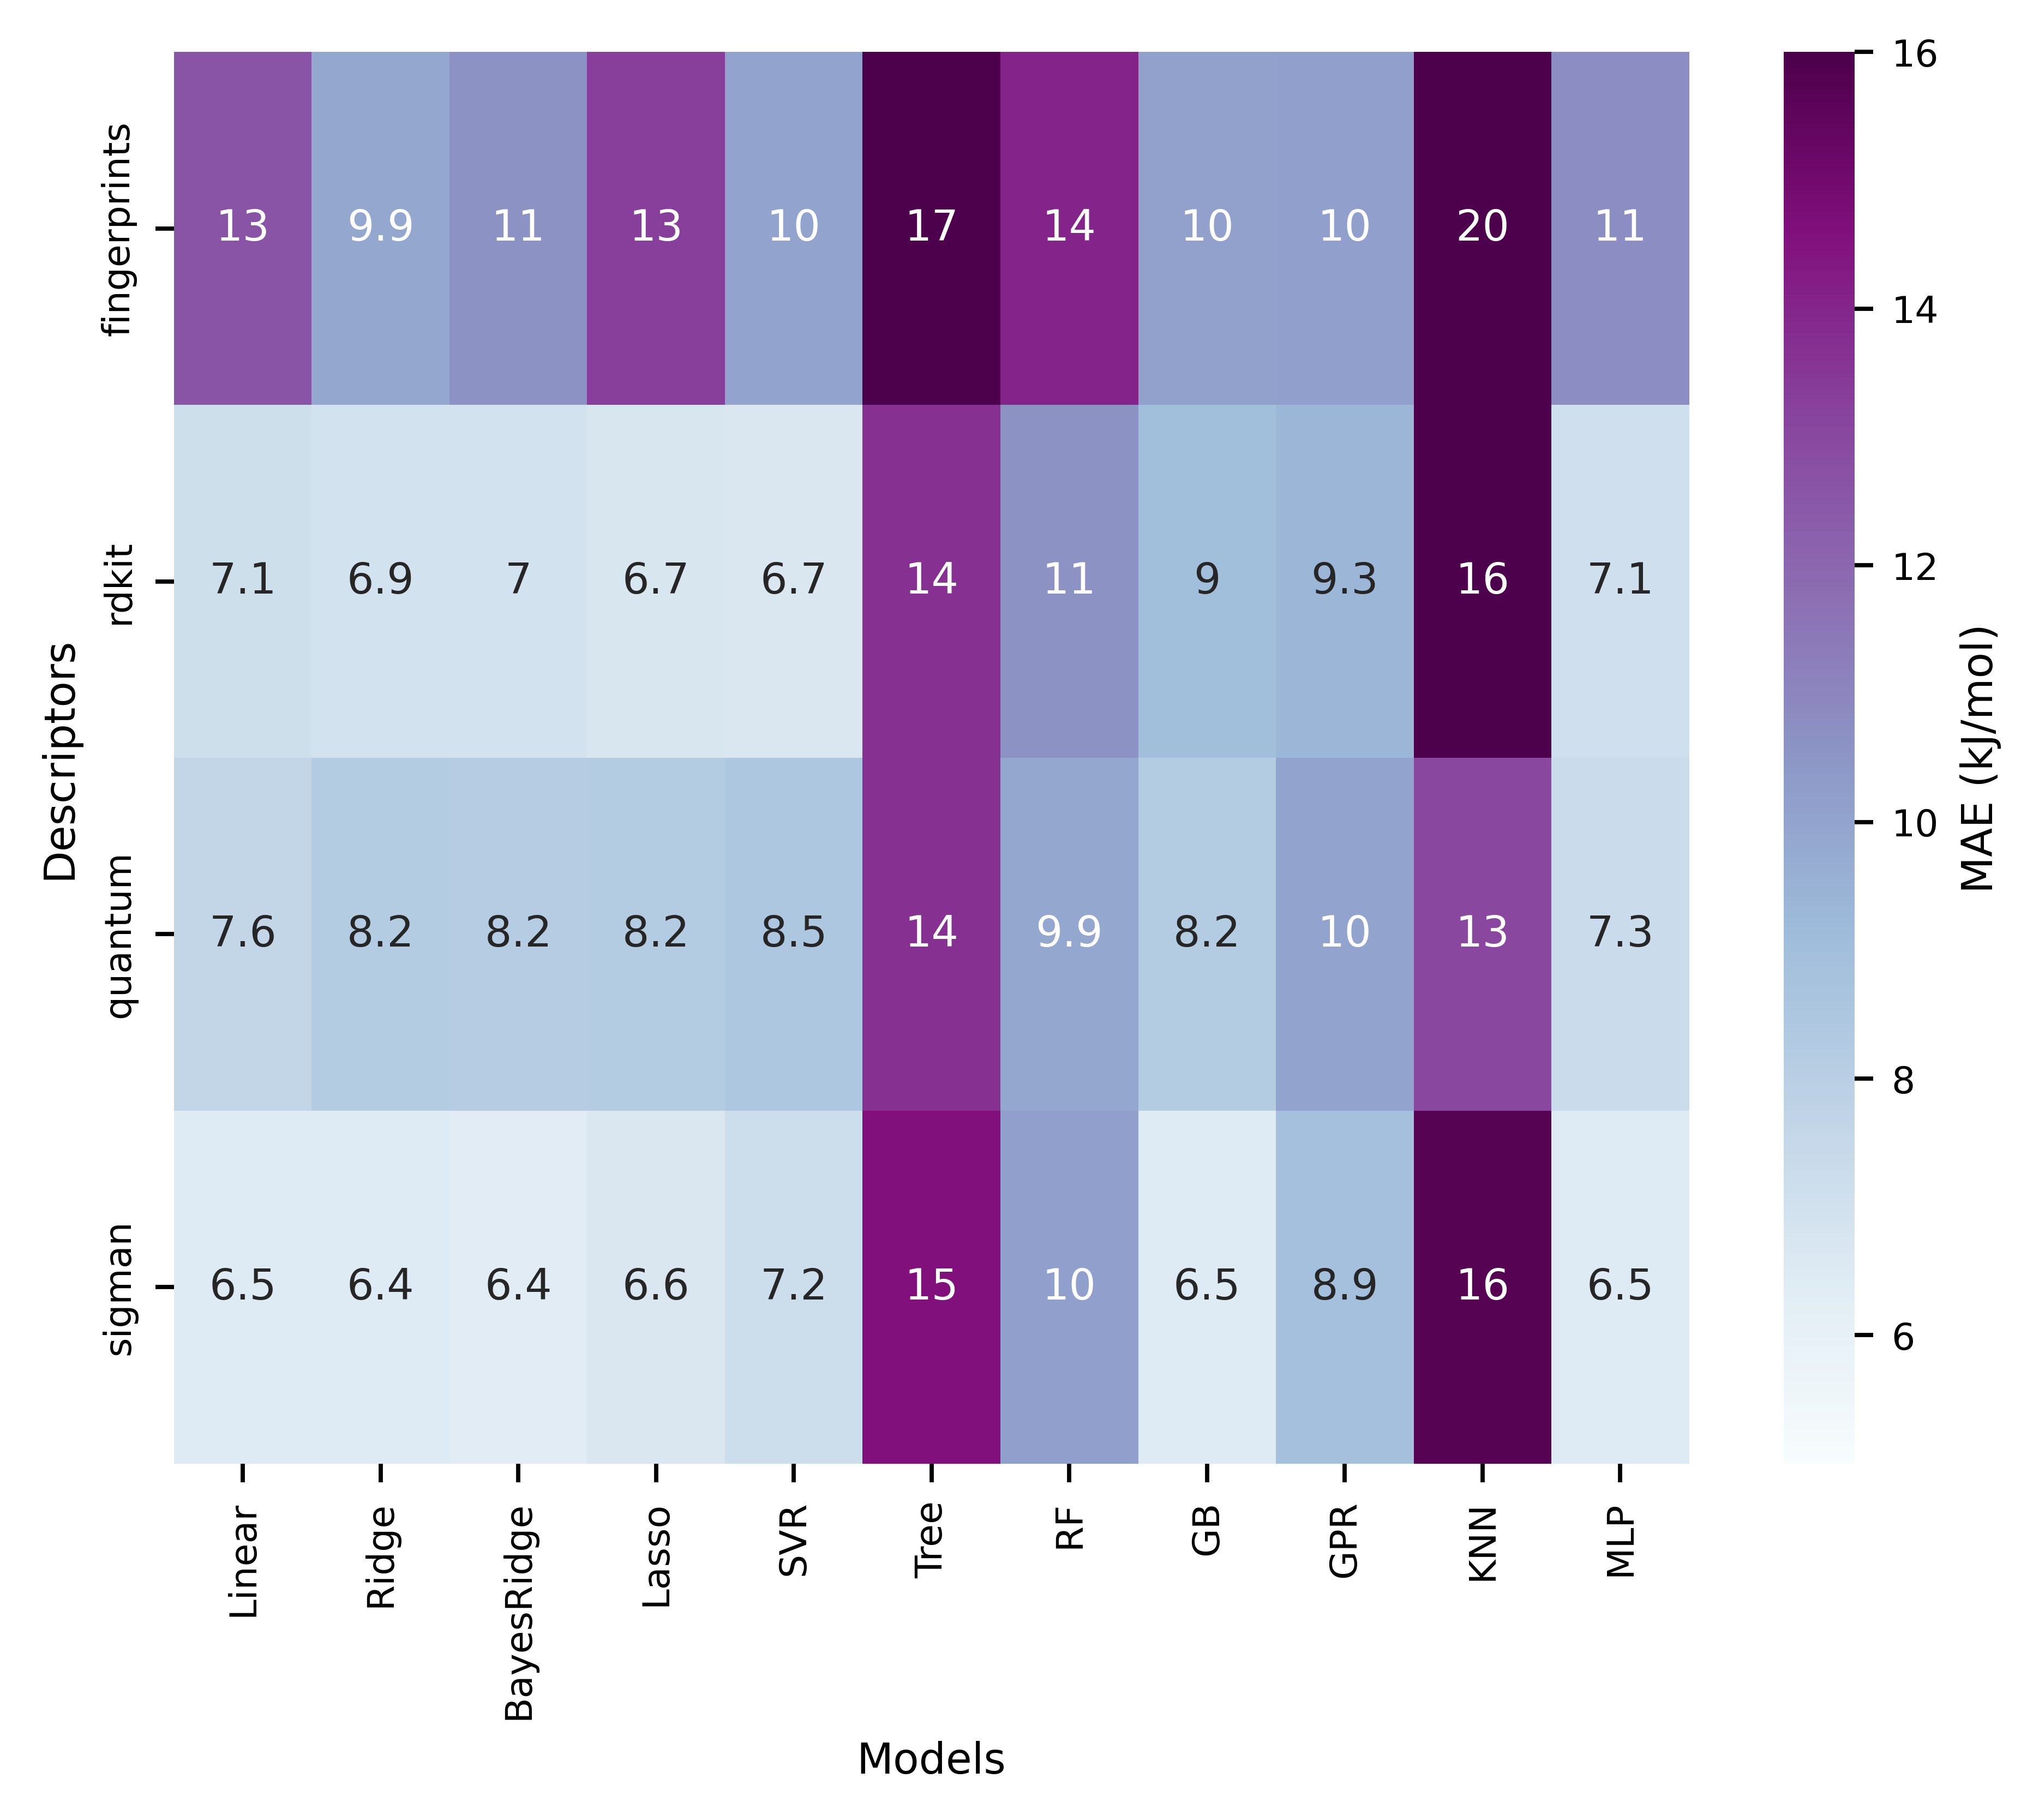

In [135]:
ax_heatmap = sns.heatmap(df_eval, annot = True, cmap = "BuPu", vmin = 5, vmax = 16)
ax_heatmap.set(xlabel = 'Models')
cbar = ax_heatmap.collections[0].colorbar
cbar.set_label('MAE (kJ/mol)')


## Boxplot

Ridge for different descriptors

In [73]:
descriptors_names = ["Fingerprints", "RDKit", "Quantum", "Hammett-extended"]

In [10]:
Y = df_ONO_train.FIA
descriptors = ['fingerprints', 'rdkit', 'quantum', 'sigman']
MAEs=[]
for descriptor in descriptors :
    print('** '+ descriptor + ' **')
    X = create_descriptors(df_ONO_train.index, descriptor, data = data_Q_tot, structure = 'ONO')
    scores = evaluate_model(dict_models['Ridge'][descriptor], X,Y)
    MAEs.append(np.absolute(scores))


** fingerprints **


TypeError: evaluate_model() missing 1 required positional argument: 'n_rep'

In [77]:
df

0          1          2          3          4          5   \
Descriptors                                                                     
0            20.225642  12.628301  12.995506  14.196100  12.968800  11.312736   
1             7.495671   6.745338   6.630609   7.102566   8.051789   6.338684   
2             6.606336  10.142663   7.113761   7.638112   8.032761   9.203224   
3             7.200706   5.528317   9.357438   5.898883   7.715632   5.121812   

                    6          7          8          9   ...         90  \
Descriptors                                              ...              
0            15.663577  21.754504  15.458165  14.804546  ...  14.599372   
1             6.429681   8.535779   7.138659   9.909038  ...   8.933090   
2             7.872431  11.392094  10.242537   7.611215  ...  10.578000   
3             4.990880   5.136975   5.576621   9.374050  ...   6.624603   

                    91         92         93         94         95         96  \
Descriptors                                                                     
0            16.829153  13.501796  16.956310  15.558489  11.457300  13.752375   
1             5.603445   8.127628   9.363210   7.056273   8.625305   9.067705   
2             8.263613   6.979993   5.760134  10.296578   7.030722   8.263115   
3             6.498632   7.581853   8.240908   6.005018   6.851262   6.164265   

                    97         98         99  
Descriptors                                   
0            11.292162  16.994591  16.686091  
1             5.696196   4.545772   6.978420  
2             9.209220   8.975398   8.982761  
3             6.565965   6.574242   4.751808  

[4 rows x 100 columns]

In [79]:
df=pd.DataFrame(MAEs)
df = df.rename_axis("Descriptors")


In [80]:
df.index = descriptors_names

In [84]:
df = df.rename_axis("Descriptors")

In [11]:
df=pd.read_csv('article/tables/MAEs_Ridge_descriptors.csv').set_index('Descriptors')

In [12]:
df

0          1          2          3          4  \
Descriptors                                                               
Fingerprints      20.225642  12.628301  12.995506  14.196100  12.968800   
RDKit              7.495671   6.745338   6.630609   7.102566   8.051789   
Quantum            6.606336  10.142663   7.113761   7.638112   8.032761   
Hammett-extended   7.200706   5.528317   9.357438   5.898883   7.715632   

                          5          6          7          8          9  ...  \
Descriptors                                                              ...   
Fingerprints      11.312736  15.663577  21.754504  15.458165  14.804546  ...   
RDKit              6.338684   6.429681   8.535779   7.138659   9.909038  ...   
Quantum            9.203224   7.872431  11.392094  10.242537   7.611215  ...   
Hammett-extended   5.121812   4.990880   5.136975   5.576621   9.374050  ...   

                         90         91         92         93         94  \
Descriptors                                                               
Fingerprints      14.599372  16.829153  13.501796  16.956310  15.558489   
RDKit              8.933090   5.603445   8.127628   9.363210   7.056273   
Quantum           10.578000   8.263613   6.979993   5.760134  10.296578   
Hammett-extended   6.624603   6.498632   7.581853   8.240908   6.005018   

                         95         96         97         98         99  
Descriptors                                                              
Fingerprints      11.457300  13.752375  11.292162  16.994591  16.686091  
RDKit              8.625305   9.067705   5.696196   4.545772   6.978420  
Quantum            7.030722   8.263115   9.209220   8.975398   8.982761  
Hammett-extended   6.851262   6.164265   6.565965   6.574242   4.751808  

[4 rows x 100 columns]

In [86]:
df.to_csv('article/tables/MAEs_Ridge_descriptors.csv')

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
X_rdkit_train = create_descriptors(df_ONO_train.index, "rdkit")
X_sigman_train = create_descriptors(df_ONO_train.index, "sigman", structure = 'ONO')
X_rdkit_sigman_ONO_train = np.concatenate((X_rdkit_train, X_sigman_train), axis = 1)
f_selector = SelectKBest(f_regression, k = 126)
f_selector.fit(X_rdkit_sigman_ONO_train, Y)
X_train = f_selector.transform(X_rdkit_sigman_ONO_train) 
scores = evaluate_model(Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06), X_train,Y)
MAEs.append(np.absolute(scores))

In [20]:
MAEs_rdkit_sigman = np.absolute(scores)

In [26]:
df.loc['RDKit & Hammett-extended'] = MAEs_rdkit_sigman

In [28]:
df.drop('RDKit & \n Hammett-extended', inplace=True)

In [29]:
df

0          1          2          3  \
Descriptors                                                            
Fingerprints              20.225642  12.628301  12.995506  14.196100   
RDKit                      7.495671   6.745338   6.630609   7.102566   
Quantum                    6.606336  10.142663   7.113761   7.638112   
Hammett-extended           7.200706   5.528317   9.357438   5.898883   
RDKit & Hammett-extended   4.517961   6.124732   8.091217   8.667490   

                                  4          5          6          7  \
Descriptors                                                            
Fingerprints              12.968800  11.312736  15.663577  21.754504   
RDKit                      8.051789   6.338684   6.429681   8.535779   
Quantum                    8.032761   9.203224   7.872431  11.392094   
Hammett-extended           7.715632   5.121812   4.990880   5.136975   
RDKit & Hammett-extended   4.764072   6.275141   6.664587   5.768879   

                                  8          9  ...         90         91  \
Descriptors                                     ...                         
Fingerprints              15.458165  14.804546  ...  14.599372  16.829153   
RDKit                      7.138659   9.909038  ...   8.933090   5.603445   
Quantum                   10.242537   7.611215  ...  10.578000   8.263613   
Hammett-extended           5.576621   9.374050  ...   6.624603   6.498632   
RDKit & Hammett-extended   7.093182   6.596330  ...   4.893251   5.244195   

                                 92         93         94         95  \
Descriptors                                                            
Fingerprints              13.501796  16.956310  15.558489  11.457300   
RDKit                      8.127628   9.363210   7.056273   8.625305   
Quantum                    6.979993   5.760134  10.296578   7.030722   
Hammett-extended           7.581853   8.240908   6.005018   6.851262   
RDKit & Hammett-extended   6.536801   7.109364   6.222518   6.094006   

                                 96         97         98         99  
Descriptors                                                           
Fingerprints              13.752375  11.292162  16.994591  16.686091  
RDKit                      9.067705   5.696196   4.545772   6.978420  
Quantum                    8.263115   9.209220   8.975398   8.982761  
Hammett-extended           6.164265   6.565965   6.574242   4.751808  
RDKit & Hammett-extended   6.515250   4.788602   7.411468   8.063124  

[5 rows x 100 columns]

In [31]:
df.to_csv('article/tables/MAEs_Ridge_descriptors.csv')

In [32]:
df=pd.read_csv('article/tables/MAEs_Ridge_descriptors.csv').set_index('Descriptors')

Text(0, 0.5, 'MAE distributions')

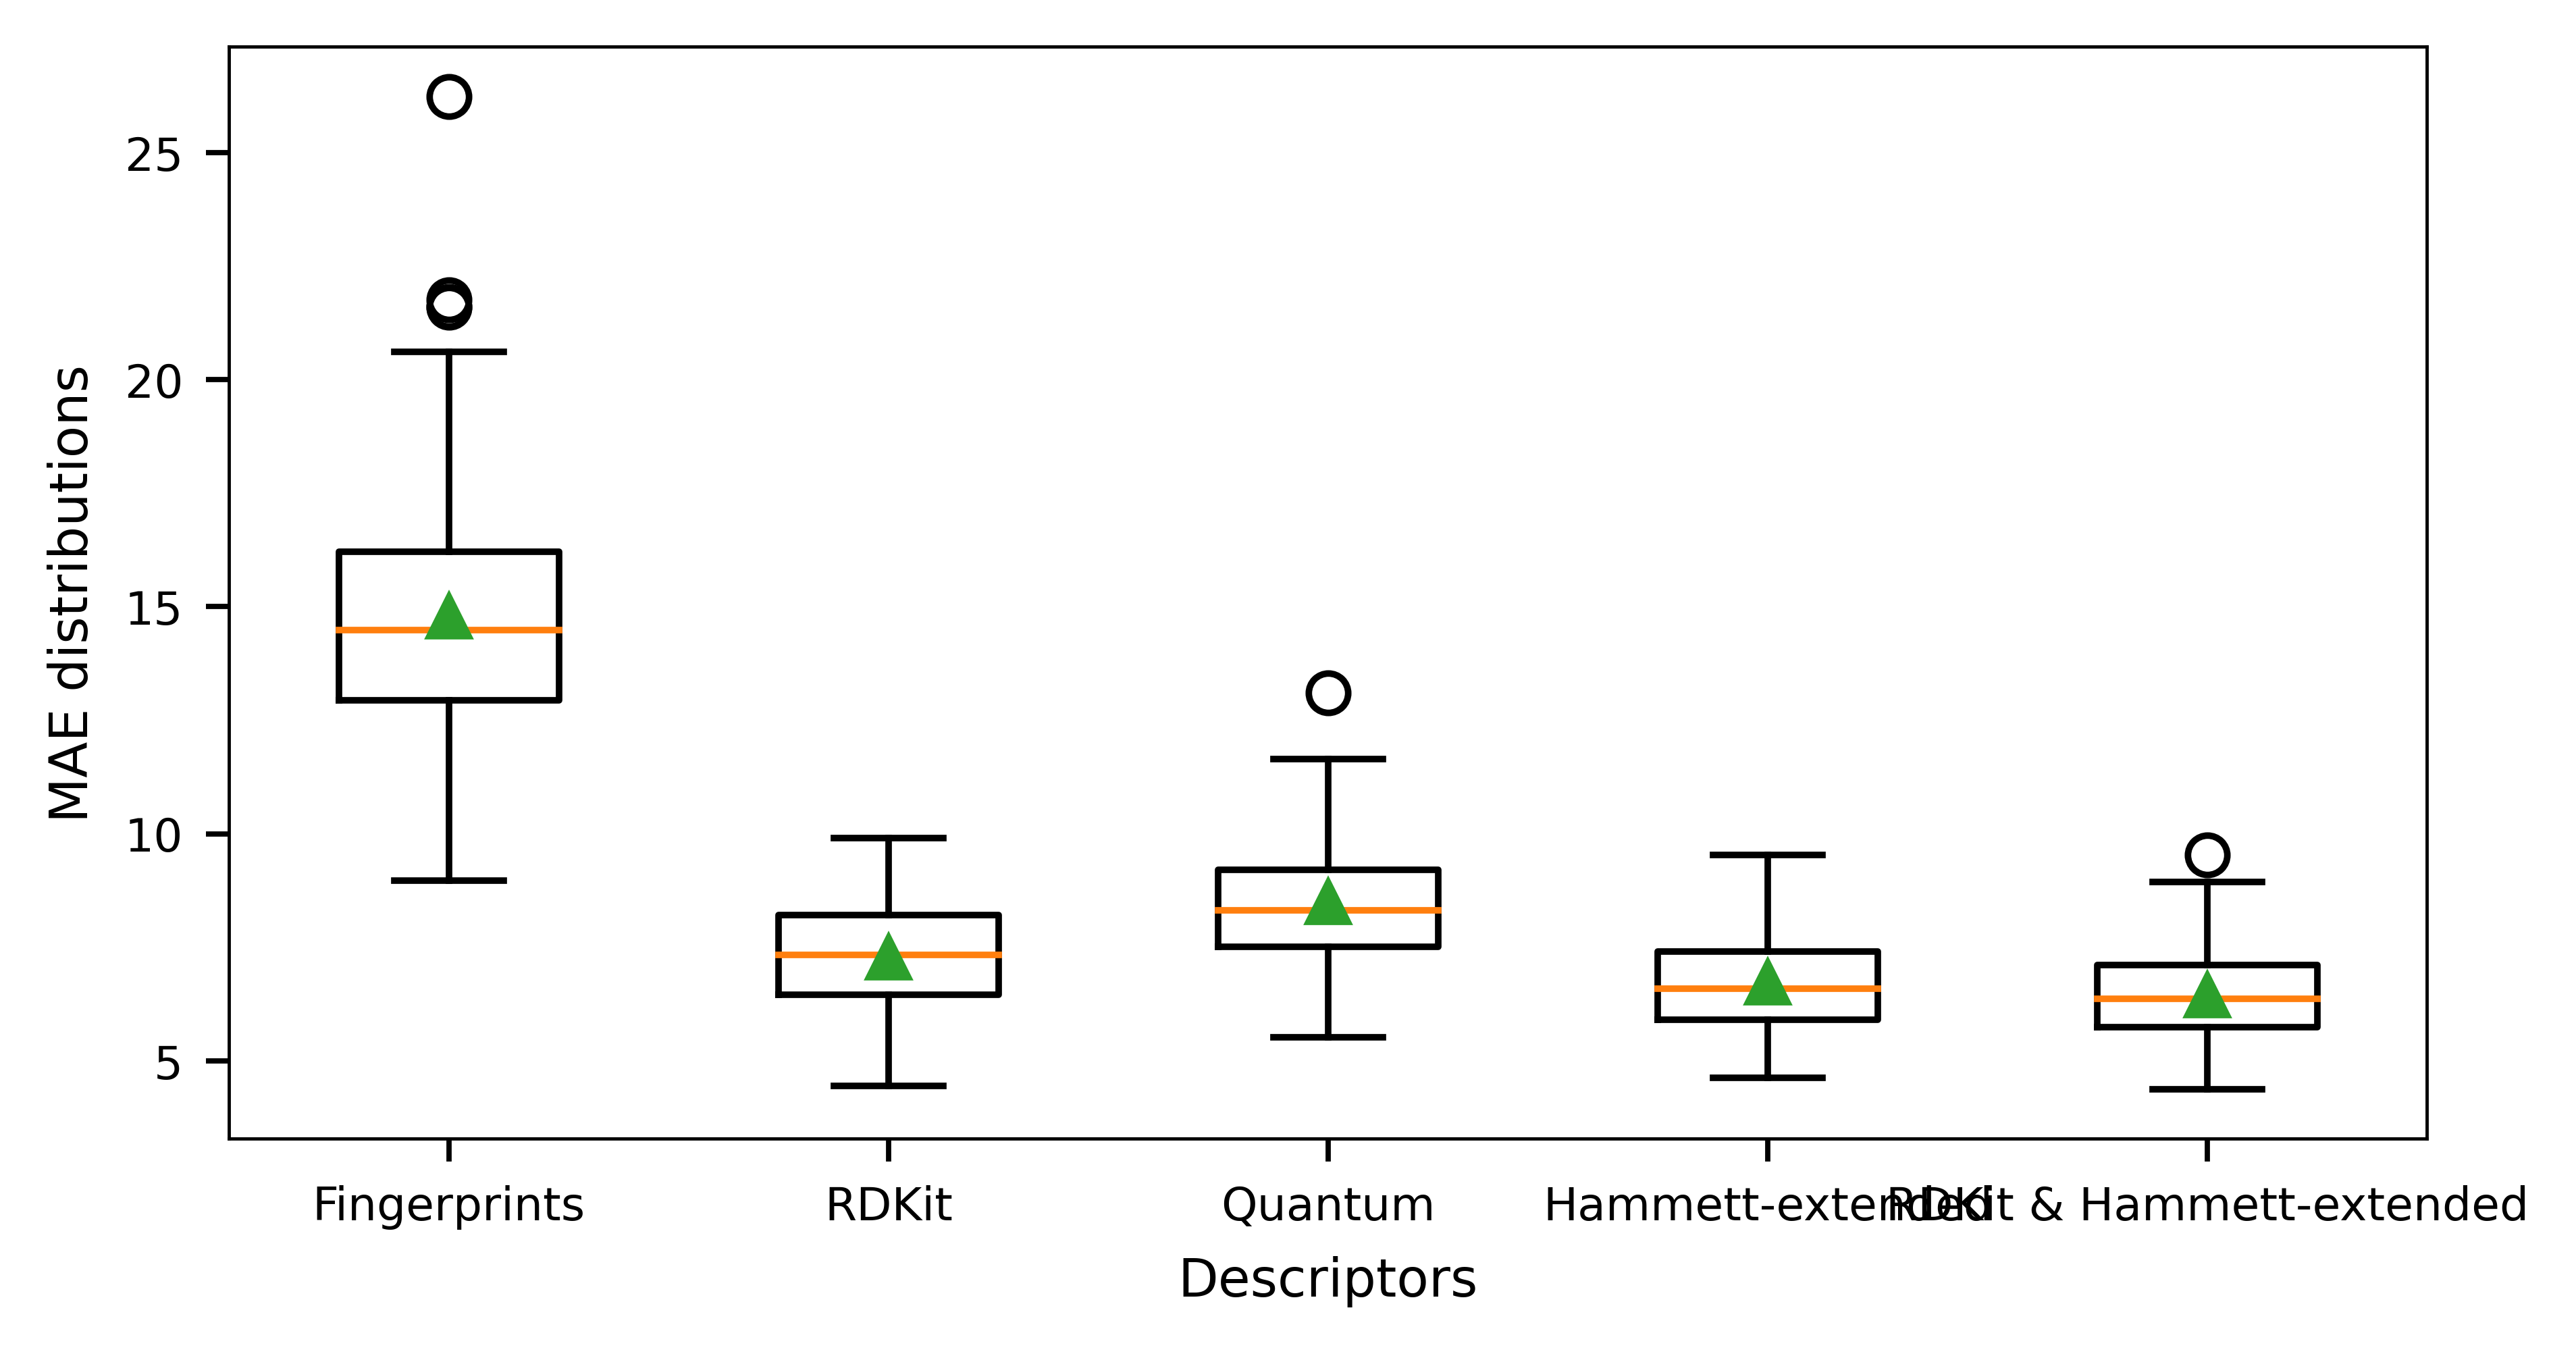

In [33]:

descriptors=df.index
MAEs=[]
for desc in descriptors:
    MAEs.append(df.loc[desc])

fig = plt.figure(figsize=(6,3))
ax = fig.subplots()

ax.boxplot(MAEs, labels=descriptors, showmeans=True, vert = True)

#ax.tick_params(axis = 'x',rotation=45)
ax.set_xlabel('Descriptors')
ax.set_ylabel('MAE distributions')

RDKit for different models

In [67]:
Y = df_ONO_train.FIA
models = df_eval.columns
MAEs=[]
X = create_descriptors(df_ONO_train.index, 'rdkit', data = data_Q_tot, structure = 'ONO')
scores = evaluate_model(dict_models["Linear"]['rdkit'], X,Y)
#MAEs.append(np.absolute(scores))

In [68]:
scores
#plt.boxplot(scores, showmeans=True, vert = True)
for mae in scores:
    if mae < -20 : 
        print(mae)

In [69]:
Y = df_ONO_train.FIA
models = df_eval.columns
MAEs=[]
X = create_descriptors(df_ONO_train.index, 'rdkit', data = data_Q_tot, structure = 'ONO')
for model in models :
    print('** '+ model + ' **')    
    scores = evaluate_model(dict_models[model]['rdkit'], X,Y)
    MAEs.append(np.absolute(scores))

** Linear **
** Ridge **
** Bayes. Ridge **
** Lasso **
** SVR **
** Tree **
** RF **
** GB **
** GPR **
** KNN **
** MLP **


In [70]:
df=pd.DataFrame(MAEs).set_index(models)
df=df.rename_axis('Models')


In [46]:
df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=200)

In [51]:
for c in df.columns:
    if df.at['Linear', c] > 20 : 
        df.at['Linear', c] = None

In [52]:
for c in df.columns:
    if df.at['Linear', c] > 20 : 
        print(df.at['Linear', c])

In [57]:
df

0          1          2          3          4  \
Models                                                                
Linear         7.483478   8.841109   8.177271   5.393598   5.535013   
Ridge          6.140031   7.589750   7.176775   7.644788   5.728083   
Bayes. Ridge   7.244589  10.702856   7.036920   6.517817   6.726509   
Lasso          6.759780   6.287992   6.265219   9.891694   7.750532   
SVR            9.876880   5.353409   7.625021   7.262551   6.896530   
Tree          11.780440  13.506975  10.607206  18.347240  21.687832   
RF             8.563854  11.407972   9.728674  10.866846  10.617685   
GB            13.308903  10.585915  10.040683   5.355624   8.435631   
GPR            7.661396   8.466247  10.147341  11.625527   9.158307   
KNN           15.729436  14.729138  21.071109  17.716025  15.625490   
MLP           10.082541   6.161932   6.961125   7.031262   8.937408   

                      5          6          7          8          9  ...  \
Models                                                               ...   
Linear         7.747485   7.395110   7.136391   9.294103   8.542640  ...   
Ridge          8.967572   7.279317   7.655904   6.596924   8.871426  ...   
Bayes. Ridge   8.224950   6.992364   6.769258   7.378849   5.955477  ...   
Lasso          7.433366   8.289737   6.730831   5.072196   6.929919  ...   
SVR            6.846562   5.915204   3.895898   6.161504   7.352574  ...   
Tree          13.257676  15.747104  13.174241  13.386229  21.305245  ...   
RF            11.850136  10.132613  10.978056  11.376886  16.127330  ...   
GB             8.792960   7.659182   7.915461  11.461032   8.219556  ...   
GPR           10.037711  11.075835  11.417508  10.536119   7.982431  ...   
KNN           17.902857  18.713016  15.690038  23.712838  15.294764  ...   
MLP            9.288189   6.346414   5.421896   5.906083   8.097070  ...   

                    190        191        192        193        194  \
Models                                                                
Linear         6.306047   8.061839   7.135228  10.902523   7.072423   
Ridge          5.834303   7.605489   6.987327   7.801031   7.860177   
Bayes. Ridge   6.826059   6.422038   7.947865   9.493863   5.667594   
Lasso          5.478217   6.919179  10.851542   9.411387   8.467144   
SVR            7.391449   7.475293   7.651200   8.395118   7.337690   
Tree          17.542973  20.713511  12.215837  12.329130  13.526709   
RF            13.551973   6.318732  11.878940   8.501030  12.063595   
GB             7.690030   7.710727  11.216354   7.759600  10.340529   
GPR            8.384494  11.500807  10.769606  11.318795   9.150876   
KNN           18.812316  14.641379  18.102913  22.730983  14.056231   
MLP            8.050600   7.422038   8.771303   8.331125   7.388931   

                    195        196        197        198        199  
Models                                                               
Linear         7.225789   5.526155   6.027404   8.491282   8.112023  
Ridge          7.004025   6.433431   5.318067   6.835913  10.468612  
Bayes. Ridge   6.963589   7.503010   7.353663   8.316099   6.728364  
Lasso          5.566449   7.119627   5.004221   6.122681   7.172214  
SVR            8.128776   6.569003   6.561163   5.975376   5.173008  
Tree          14.276083   8.725764  22.134535  21.049348  10.532165  
RF            11.439286  12.786624  12.376129  12.505816  10.534912  
GB            12.001350   9.988236   7.802569   8.641735  13.770815  
GPR            9.203840  10.998616   8.286048  11.363549   9.704930  
KNN           24.534671  14.116891  14.674585  15.148729  16.241680  
MLP            6.281557   6.555582   6.157322   6.241559   8.867657  

[11 rows x 200 columns]

In [59]:
df.loc['Linear']

0      7.483478
1      8.841109
2      8.177271
3      5.393598
4      5.535013
         ...   
195    7.225789
196    5.526155
197    6.027404
198    8.491282
199    8.112023
Name: Linear, Length: 200, dtype: float64

In [71]:
df.to_csv('article/tables/MAEs_rdkit_models.csv')

Text(0, 0.5, 'MAE distributions')

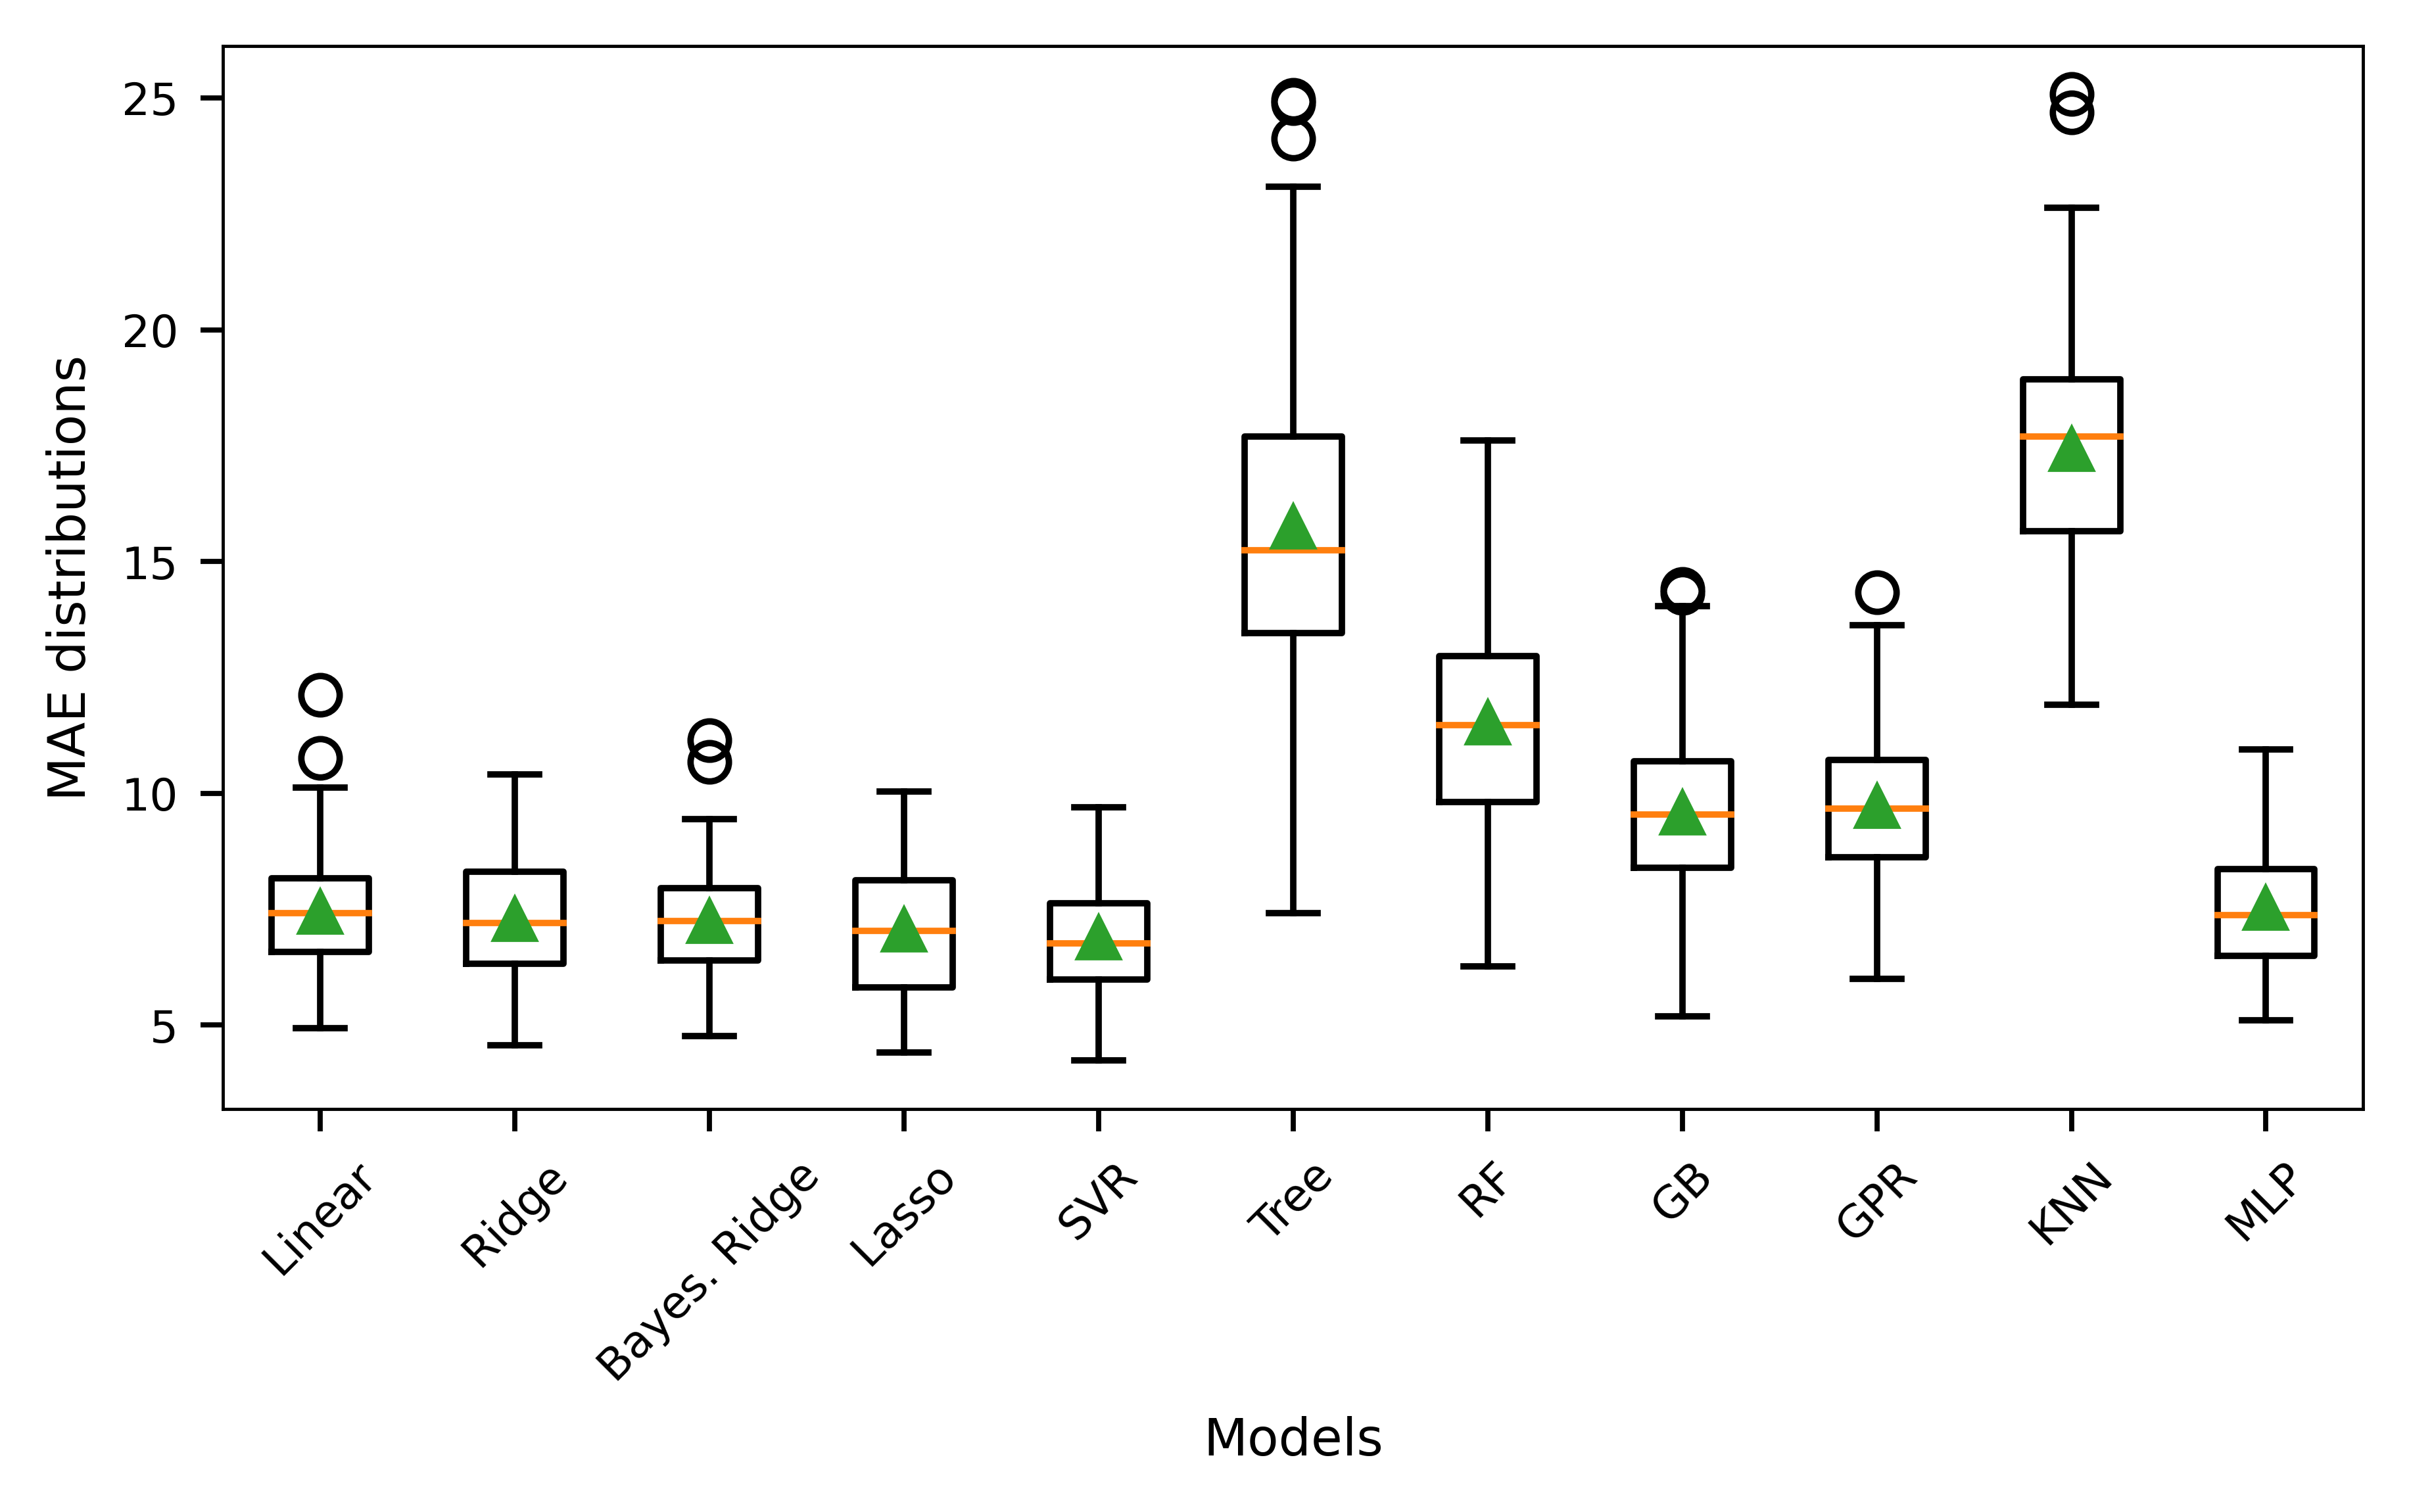

In [72]:
##ridge and various descriptors

df = pd.read_csv('article/tables/MAEs_rdkit_models.csv').set_index('Models')
models=df.index
MAEs=[]
for model in models:
    MAEs.append(df.loc[model])

fig = plt.figure(figsize=(6,3))
ax = fig.subplots()

ax.boxplot(MAEs, labels=models, showmeans=True, vert = True)

ax.tick_params(axis = 'x',rotation=45)
ax.set_xlabel('Models')
ax.set_ylabel('MAE distributions')



## Global figure

In [16]:
df_eval = pd.read_csv('article/tables/table_models_eval_ONO_on_test_set.csv')
df_eval = df_eval.set_index('Descriptors')

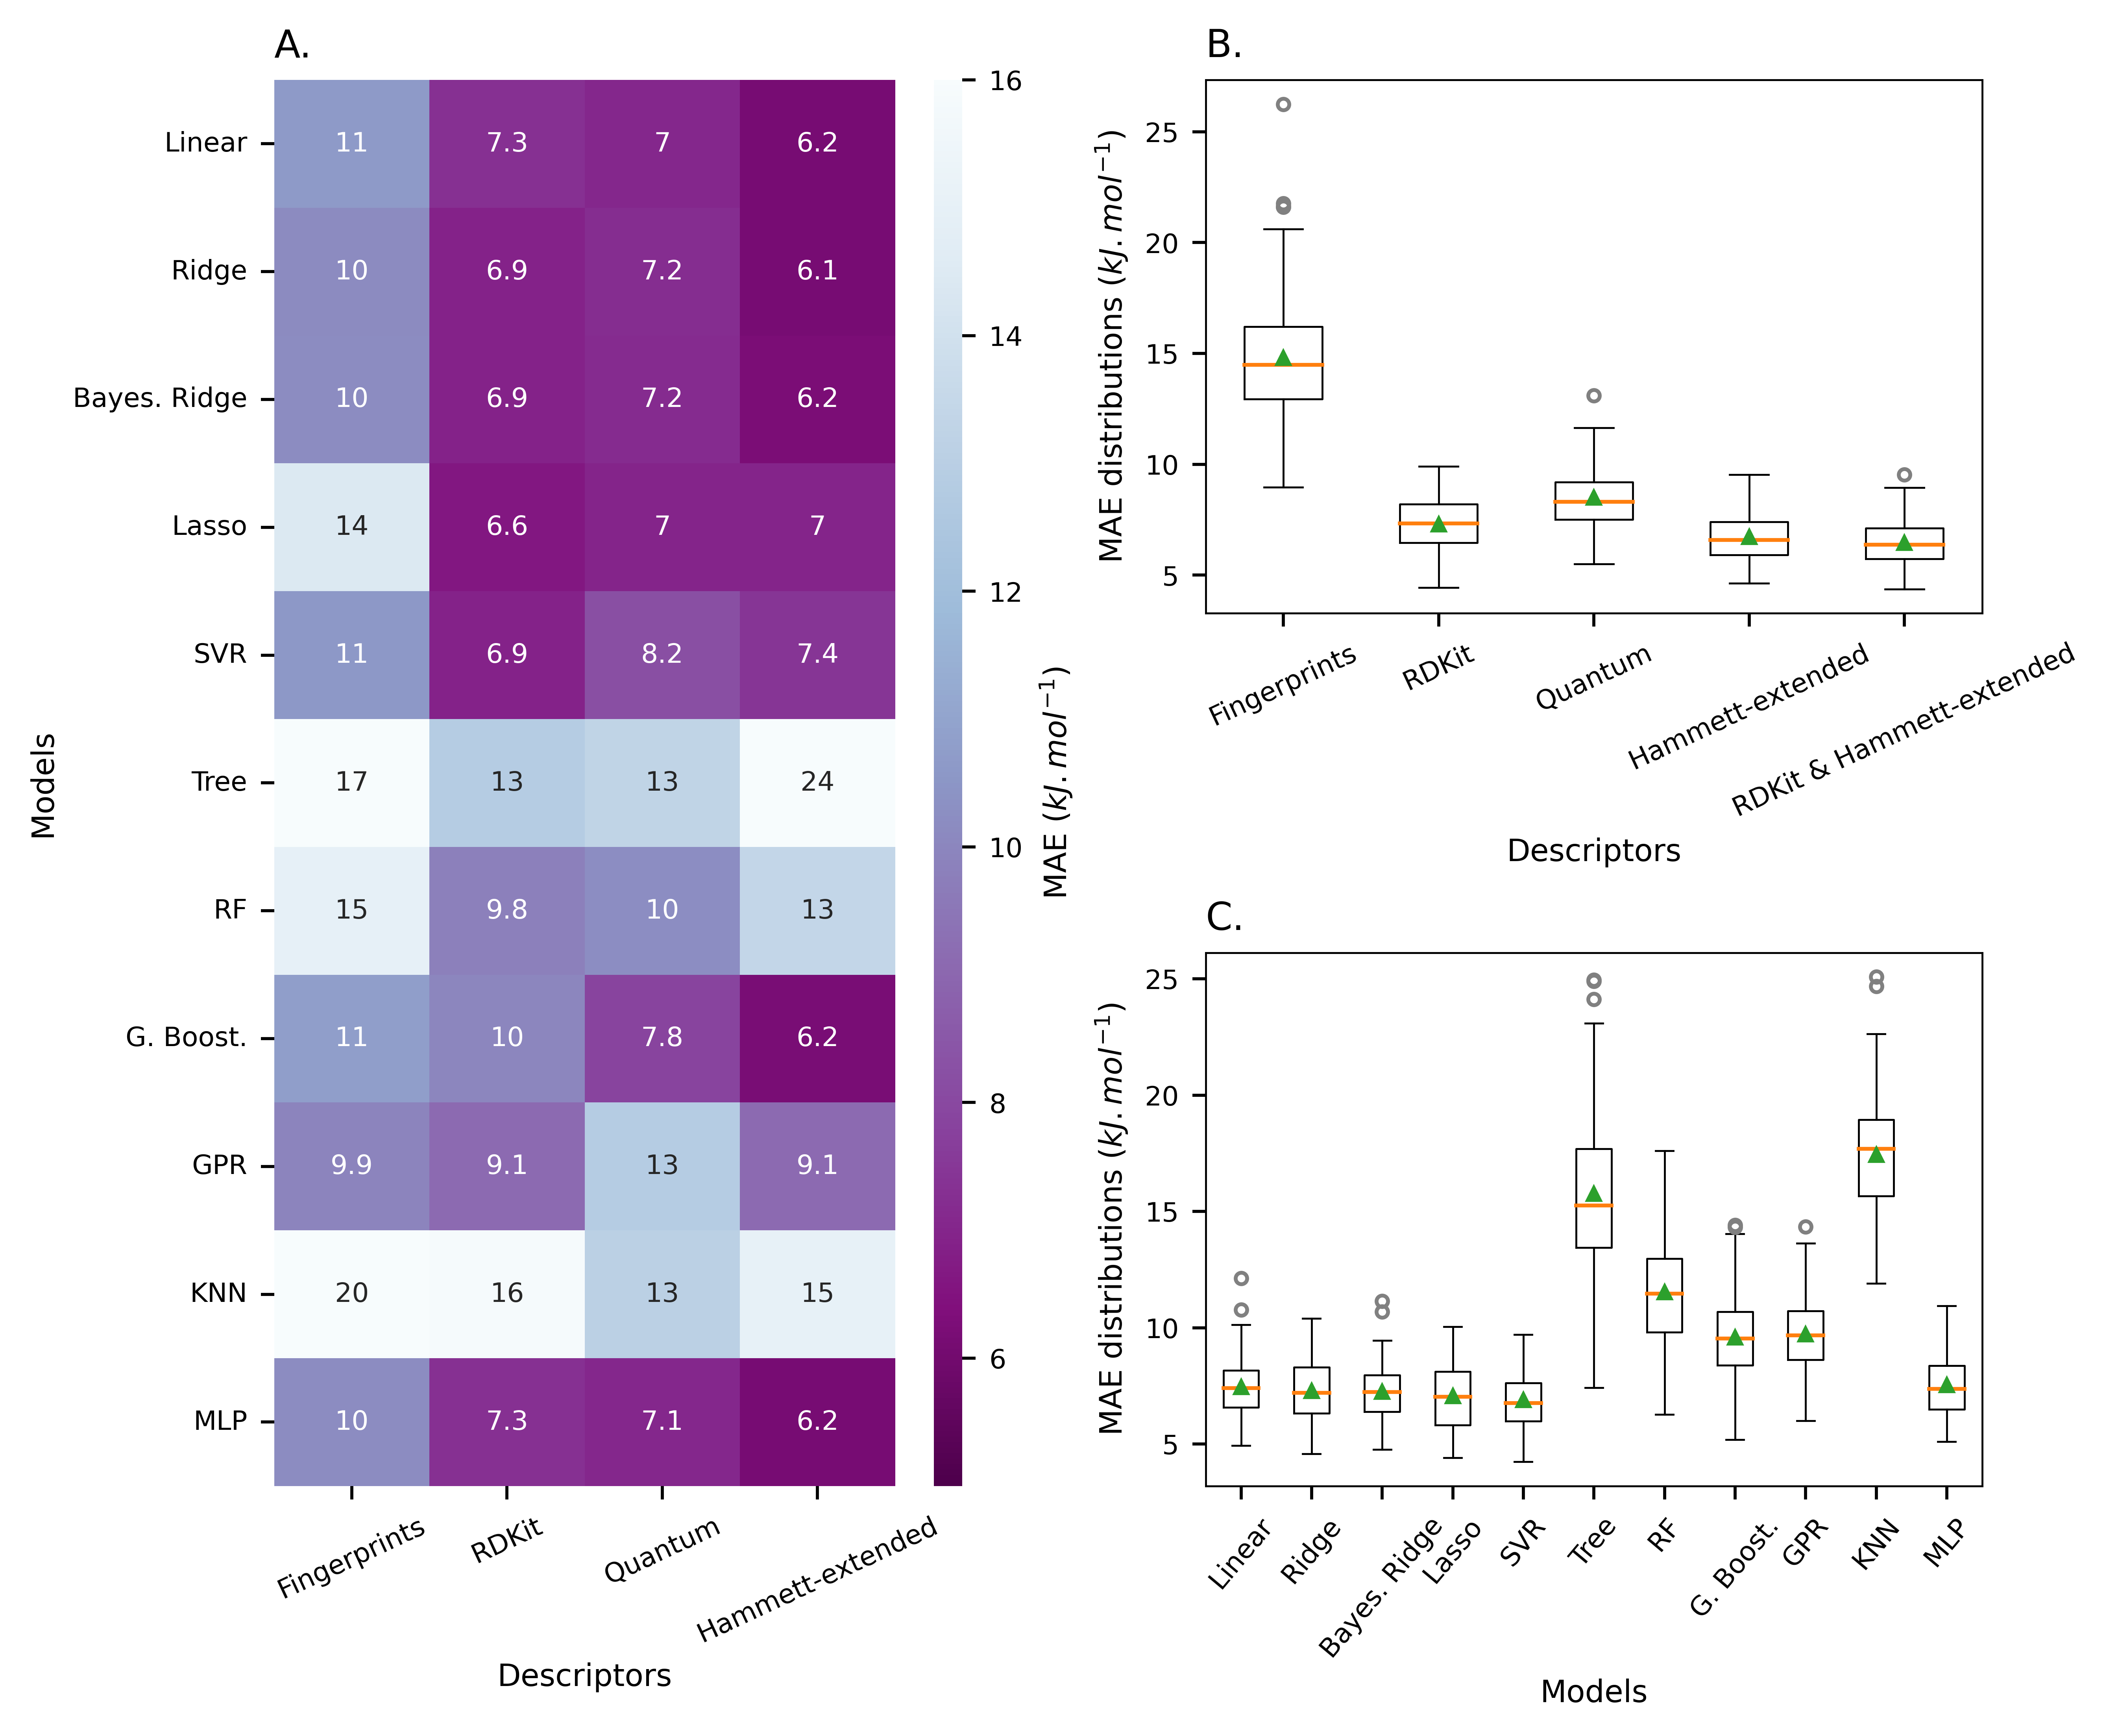

In [18]:
fig = plt.figure(figsize = (8, 8))

## heatmap ##

#ax1 = fig.add_subplot(1, 3, 1)
#sns.cubehelix_palette(as_cmap=True)

ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan = 5)

ax2 = plt.subplot2grid((6, 2), (0, 1), rowspan = 2)
ax3 = plt.subplot2grid((6, 2), (3, 1), rowspan = 2)


heatmap = sns.heatmap(df_eval.T, ax=ax1, cmap = 'BuPu_r',annot = True, fmt='.2g', vmin = 5, vmax = 16, cbar=False)
ax1.set(xlabel = 'Descriptors')
ax1.tick_params(axis = 'x',rotation=25)
ax1.set(ylabel = 'Models')
ax1.tick_params(axis = 'y',rotation=0)
cbar = fig.colorbar(heatmap.get_children()[0], ax=ax1, aspect = 50)
cbar.set_label('MAE ($kJ.mol^{-1}$)')
cbar.outline.set_visible(False)

ax1.set_title("A.", loc='left', fontsize =10)


## 1ere boxplot ##

boxprops = dict(linewidth=0.5)
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)
flierprops = dict(markersize = 3, markeredgecolor='grey')
meanprops = dict(markersize = 3)

df=pd.read_csv('article/tables/MAEs_Ridge_descriptors.csv').set_index('Descriptors')
descriptors=df.index
MAEs=[]
for desc in descriptors:
    MAEs.append(df.loc[desc])




box1 = ax2.boxplot(MAEs, labels=descriptors, showmeans=True, vert = True, 
                   boxprops = boxprops, whiskerprops = whiskerprops, 
                   capprops=capprops, flierprops = flierprops, meanprops = meanprops)


ax2.tick_params(axis = 'x',rotation=25)
ax2.set_xlabel('Descriptors')
ax2.set_ylabel('MAE distributions ($kJ.mol^{-1}$)')

ax2.set_title("B.", loc='left', fontsize =10)


## 2eme boxplot ##

df = pd.read_csv('article/tables/MAEs_rdkit_models.csv').set_index('Models')
models=df.index
MAEs=[]
for model in models:
    MAEs.append(df.loc[model])




box2 = ax3.boxplot(MAEs, labels=models, showmeans=True, vert = True, boxprops = boxprops, whiskerprops = whiskerprops, 
                   capprops=capprops, flierprops = flierprops, meanprops = meanprops)

ax3.tick_params(axis = 'x',rotation=50)
ax3.set_xlabel('Models')
ax3.set_ylabel('MAE distributions ($kJ.mol^{-1}$)')

ax3.set_title("C.", loc='left', fontsize =10)


fig.savefig('article/figures/benchmarking_models_descriptors.png', transparent= True, facecolor='white', bbox_inches='tight')

## Poster

In [6]:
rc('font', family='sans-serif', size = 15)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 16)
rc('legend', fontsize=18)
rc('lines', linewidth = 3)
rc('axes', linewidth = 1)
rc('axes', labelsize = 17)
rc('legend', handlelength = 2)

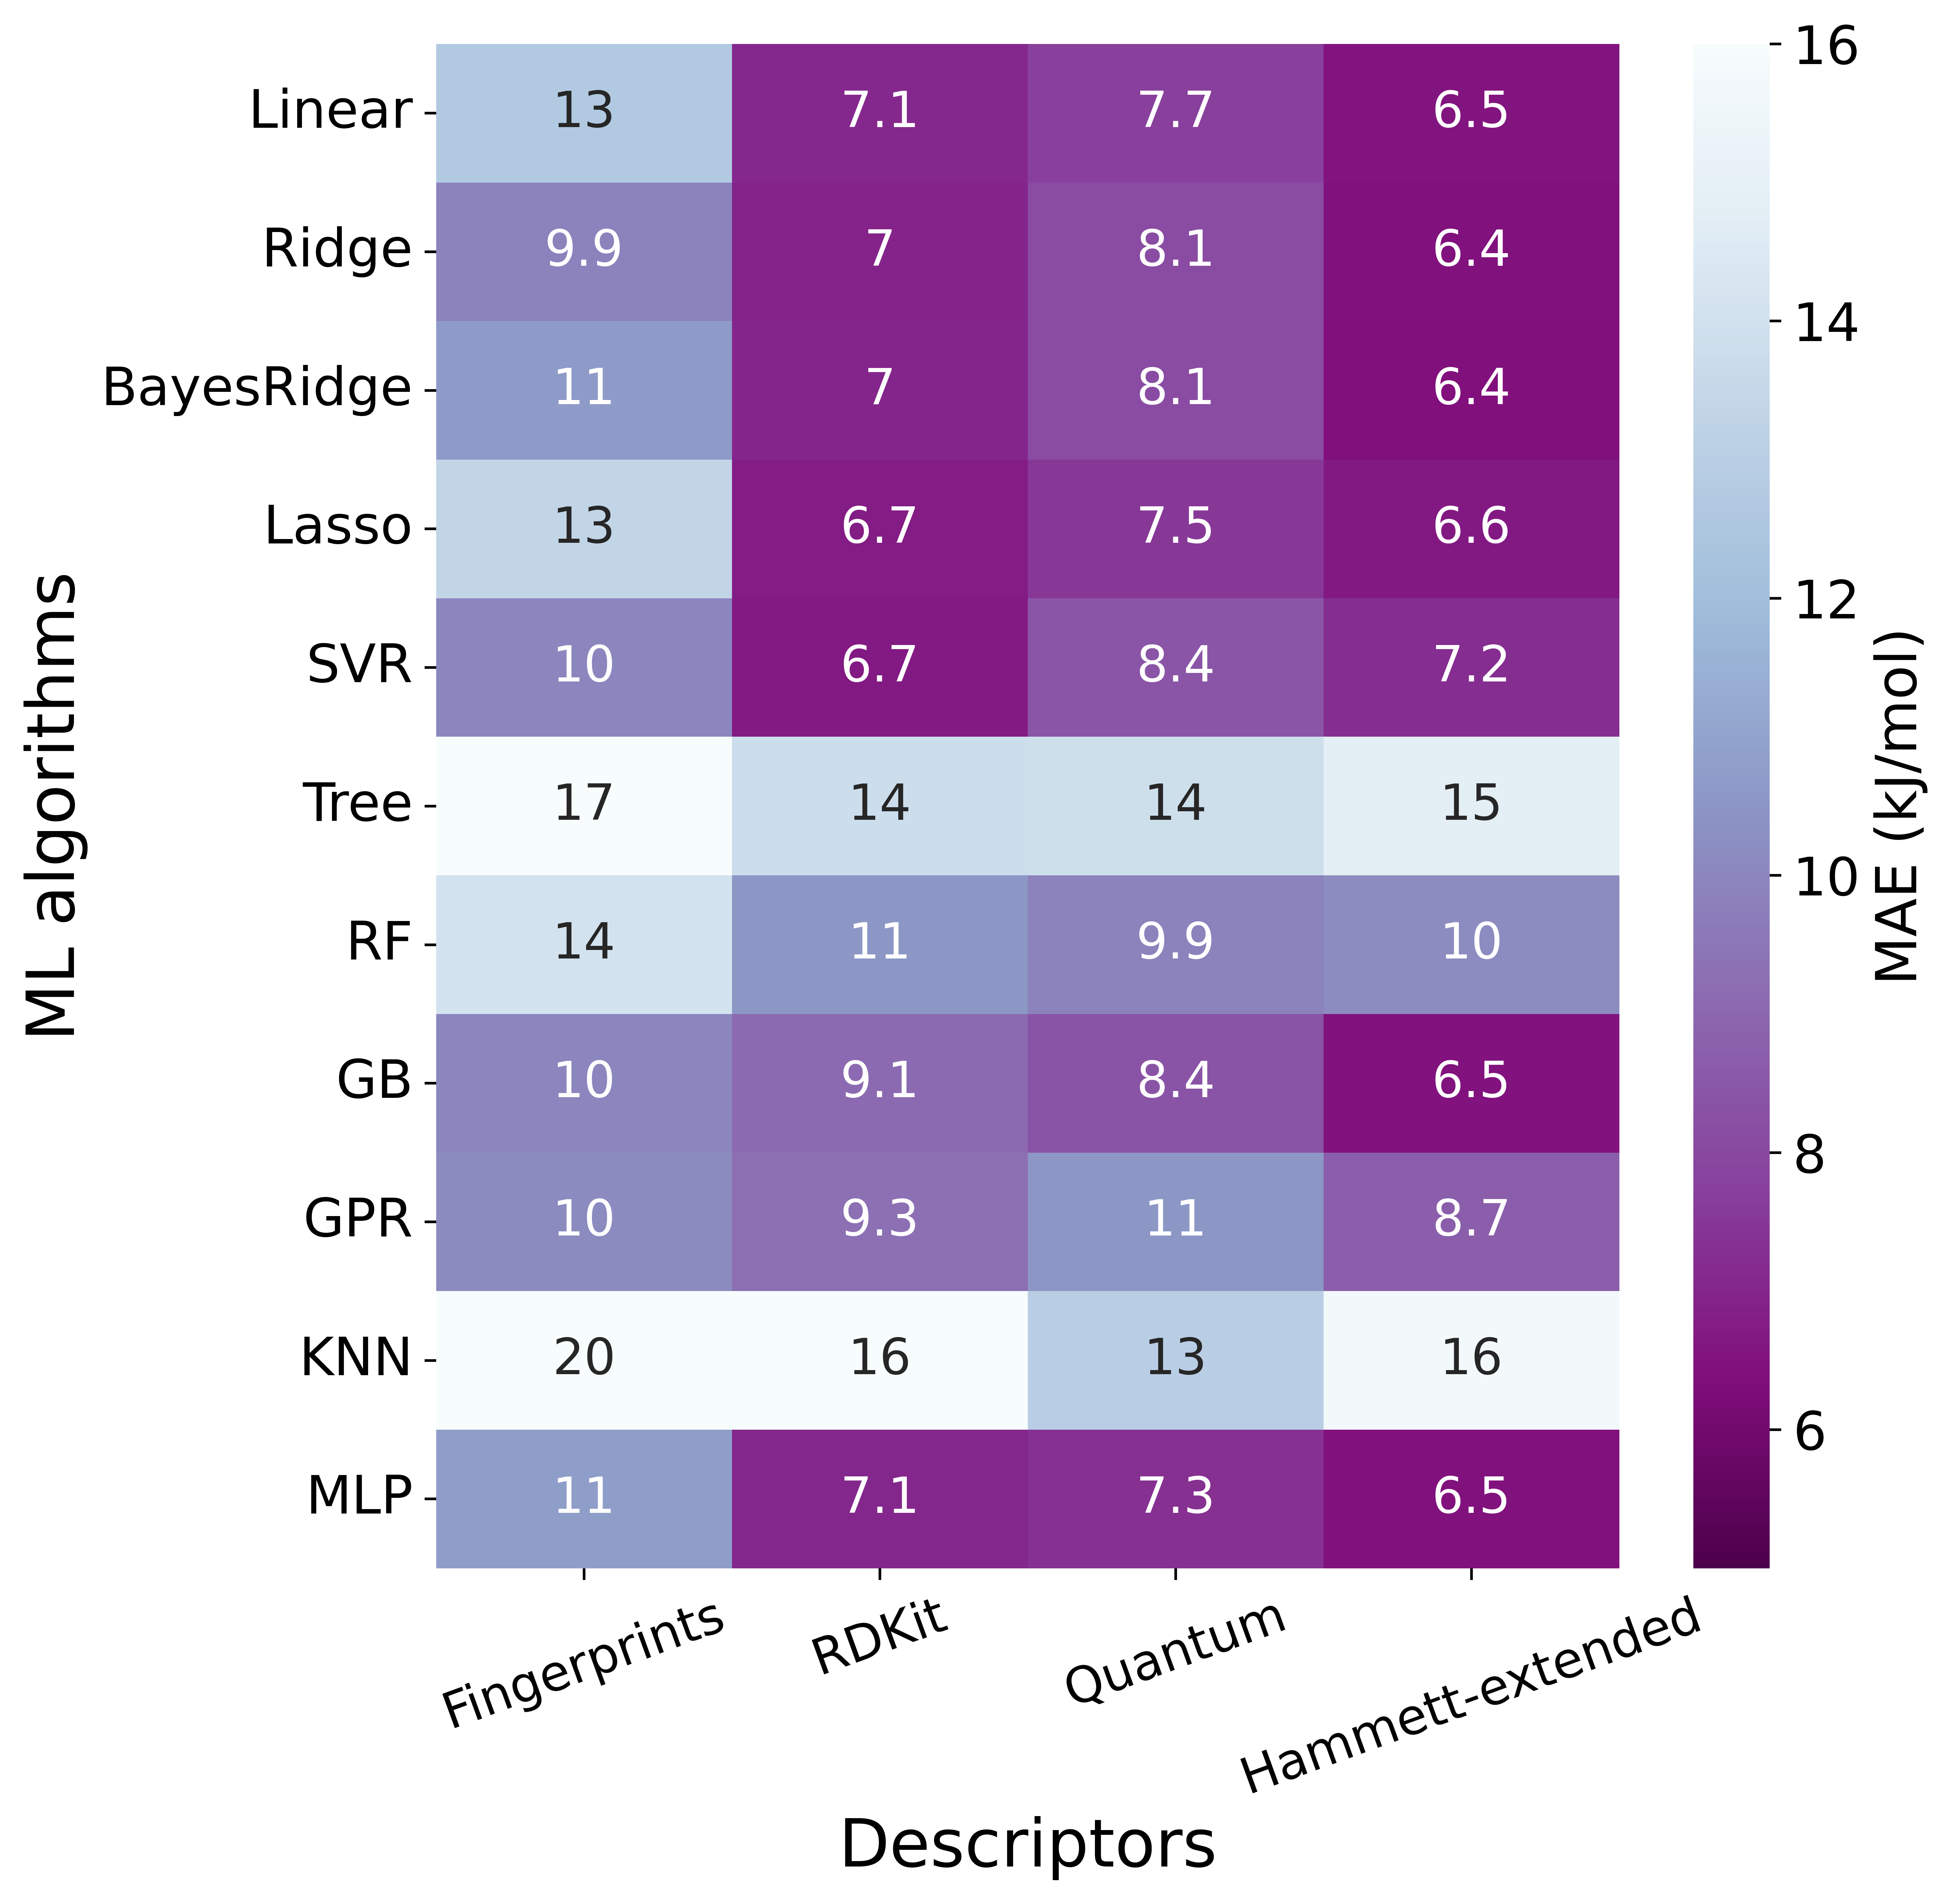

In [9]:


fig,ax = plt.subplots(figsize = (8,8.3))



##1st graph :

df_eval = pd.read_csv('article/tables/table_models_eval_ONO.csv').set_index('Descriptors')

heatmap = sns.heatmap(df_eval.T, annot = True, cmap = "BuPu_r", vmin = 5, vmax = 16, ax = ax, cbar = False)
ax.set_ylabel('ML algorithms', fontsize = 20)
ax.set_xlabel('Descriptors', fontsize = 20)

cbar = fig.colorbar(heatmap.get_children()[0], ax=ax, aspect = 20)
cbar.set_label('MAE (kJ/mol)', fontsize = 17)
cbar.outline.set_visible(False)

plt.xticks(rotation = 20, fontsize = 15)




fig.savefig('figures/poster/models_evaluation_descriptors.svg', format = 'svg', transparent= True, bbox_inches='tight')


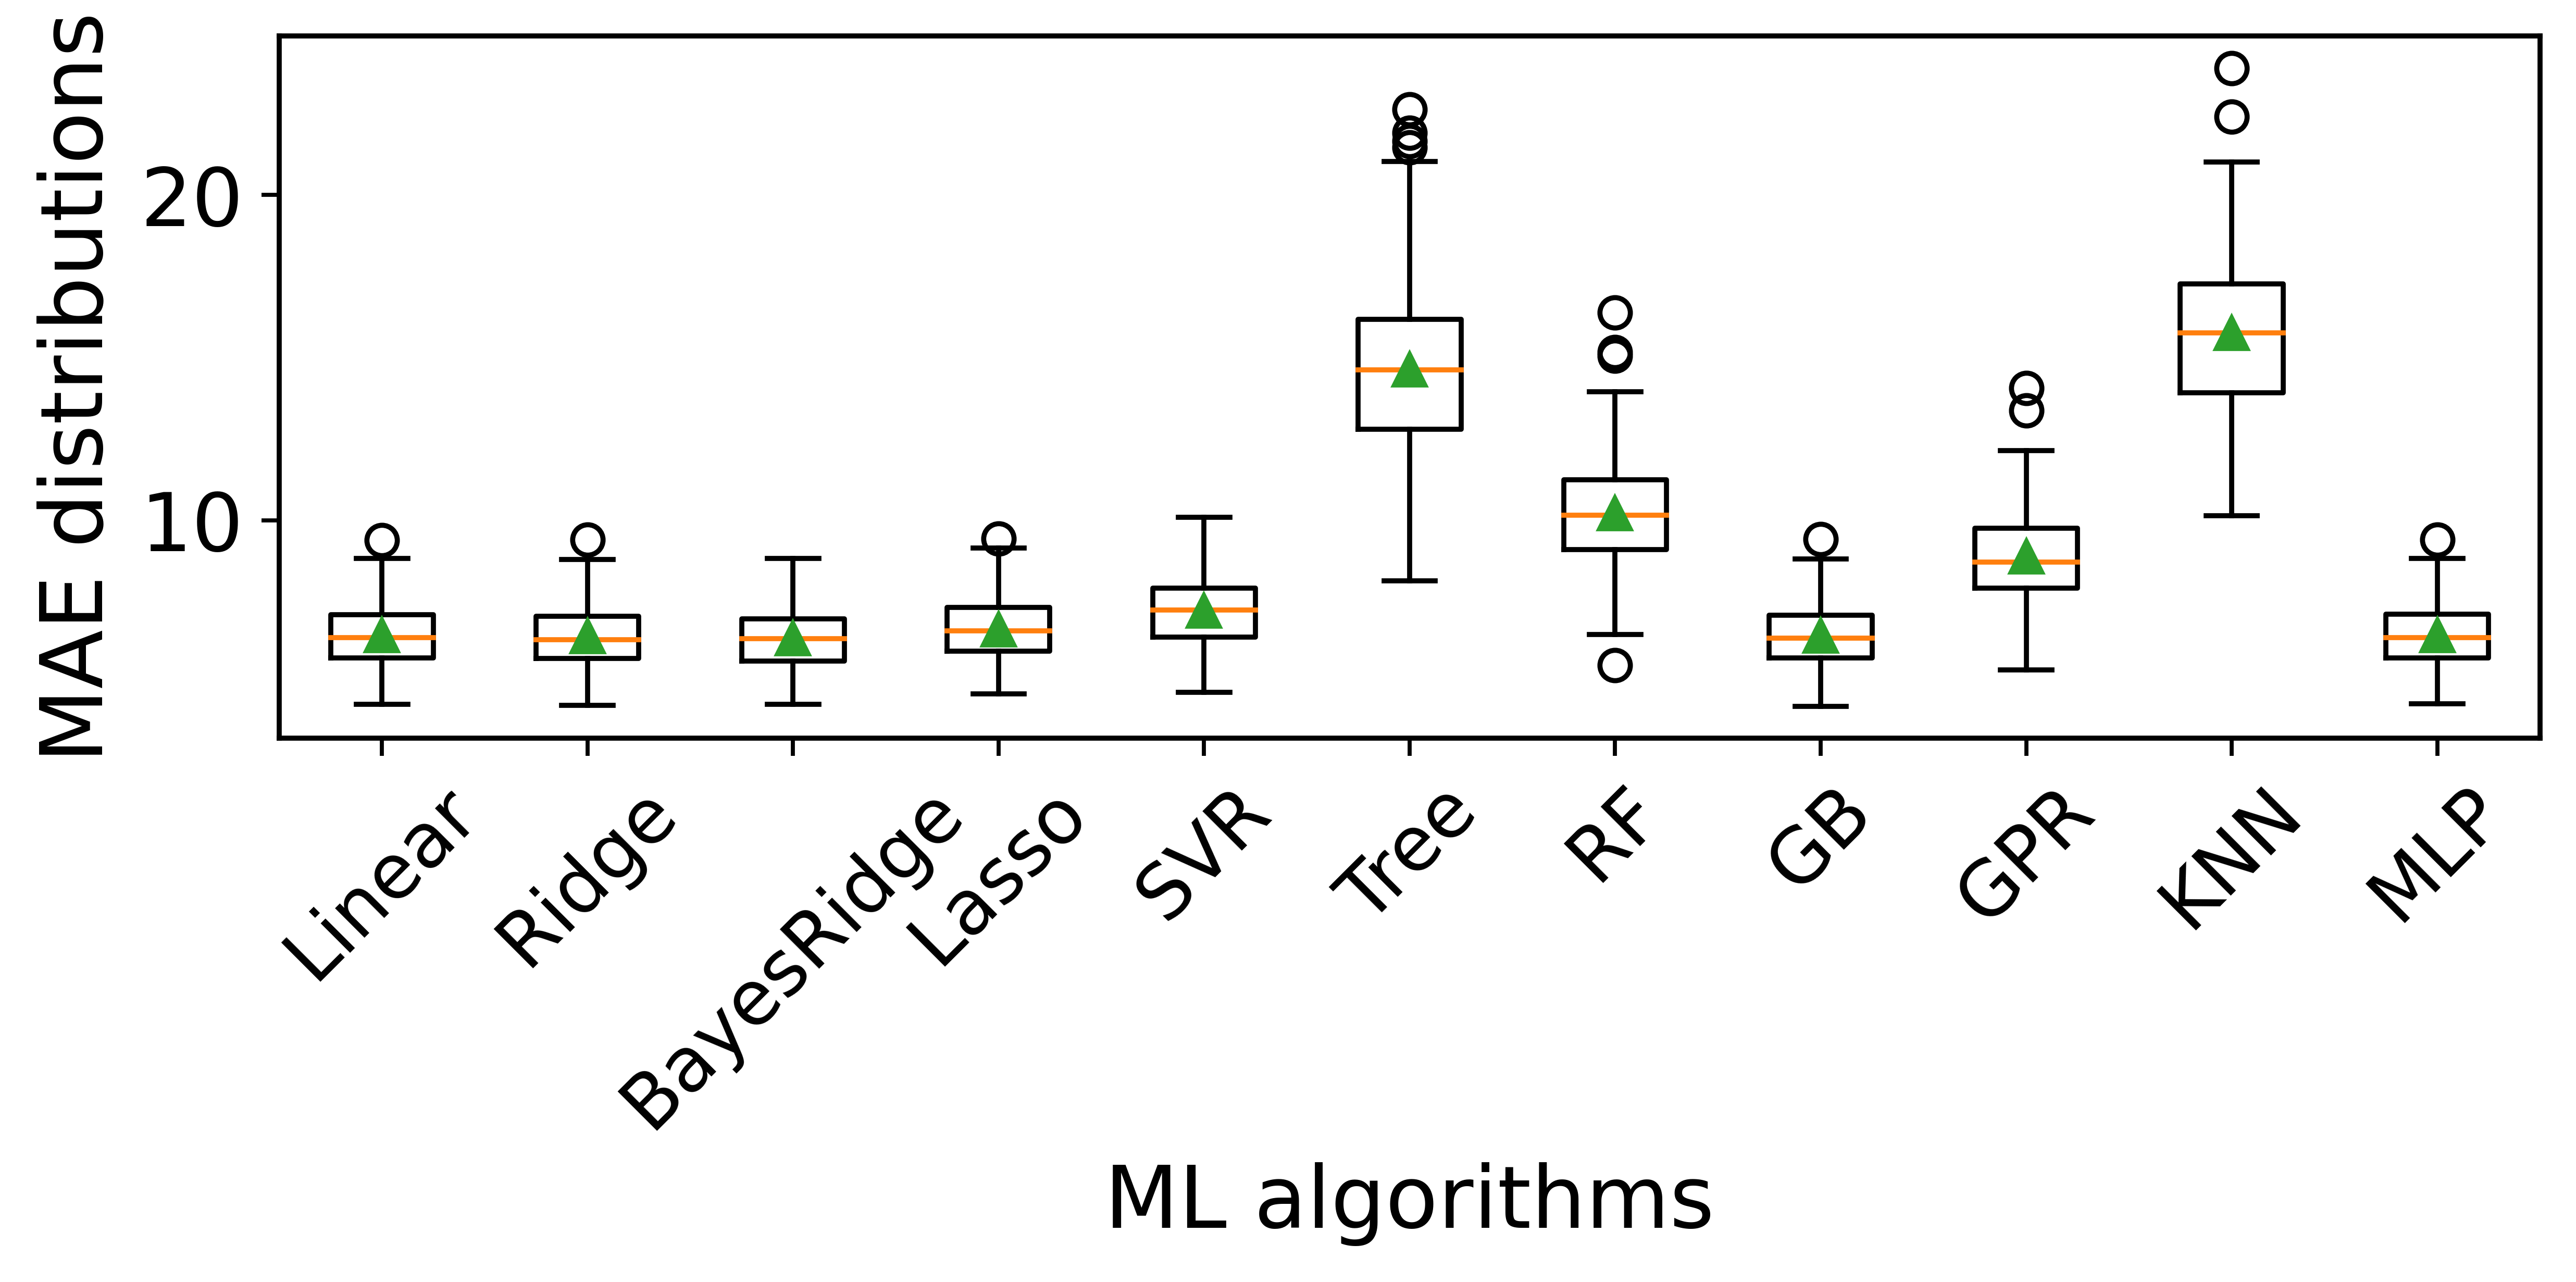

In [7]:
## 2nd graph
fig,ax2 = plt.subplots(figsize=(8, 2.5))
df = pd.read_csv('article/tables/MAEs_sigman_models.csv').set_index('Models')
models=df.index
MAEs=[]
for model in models:
    MAEs.append(df.loc[model])

ax2.boxplot(MAEs, labels=models, showmeans=True, vert = True)

plt.xticks(rotation=45, fontsize = 15)
ax2.set_xlabel('ML algorithms')
ax2.set_ylabel('MAE distributions')

fig.savefig('figures/poster/boxplot_models.svg', format = 'svg', transparent= True, bbox_inches='tight')

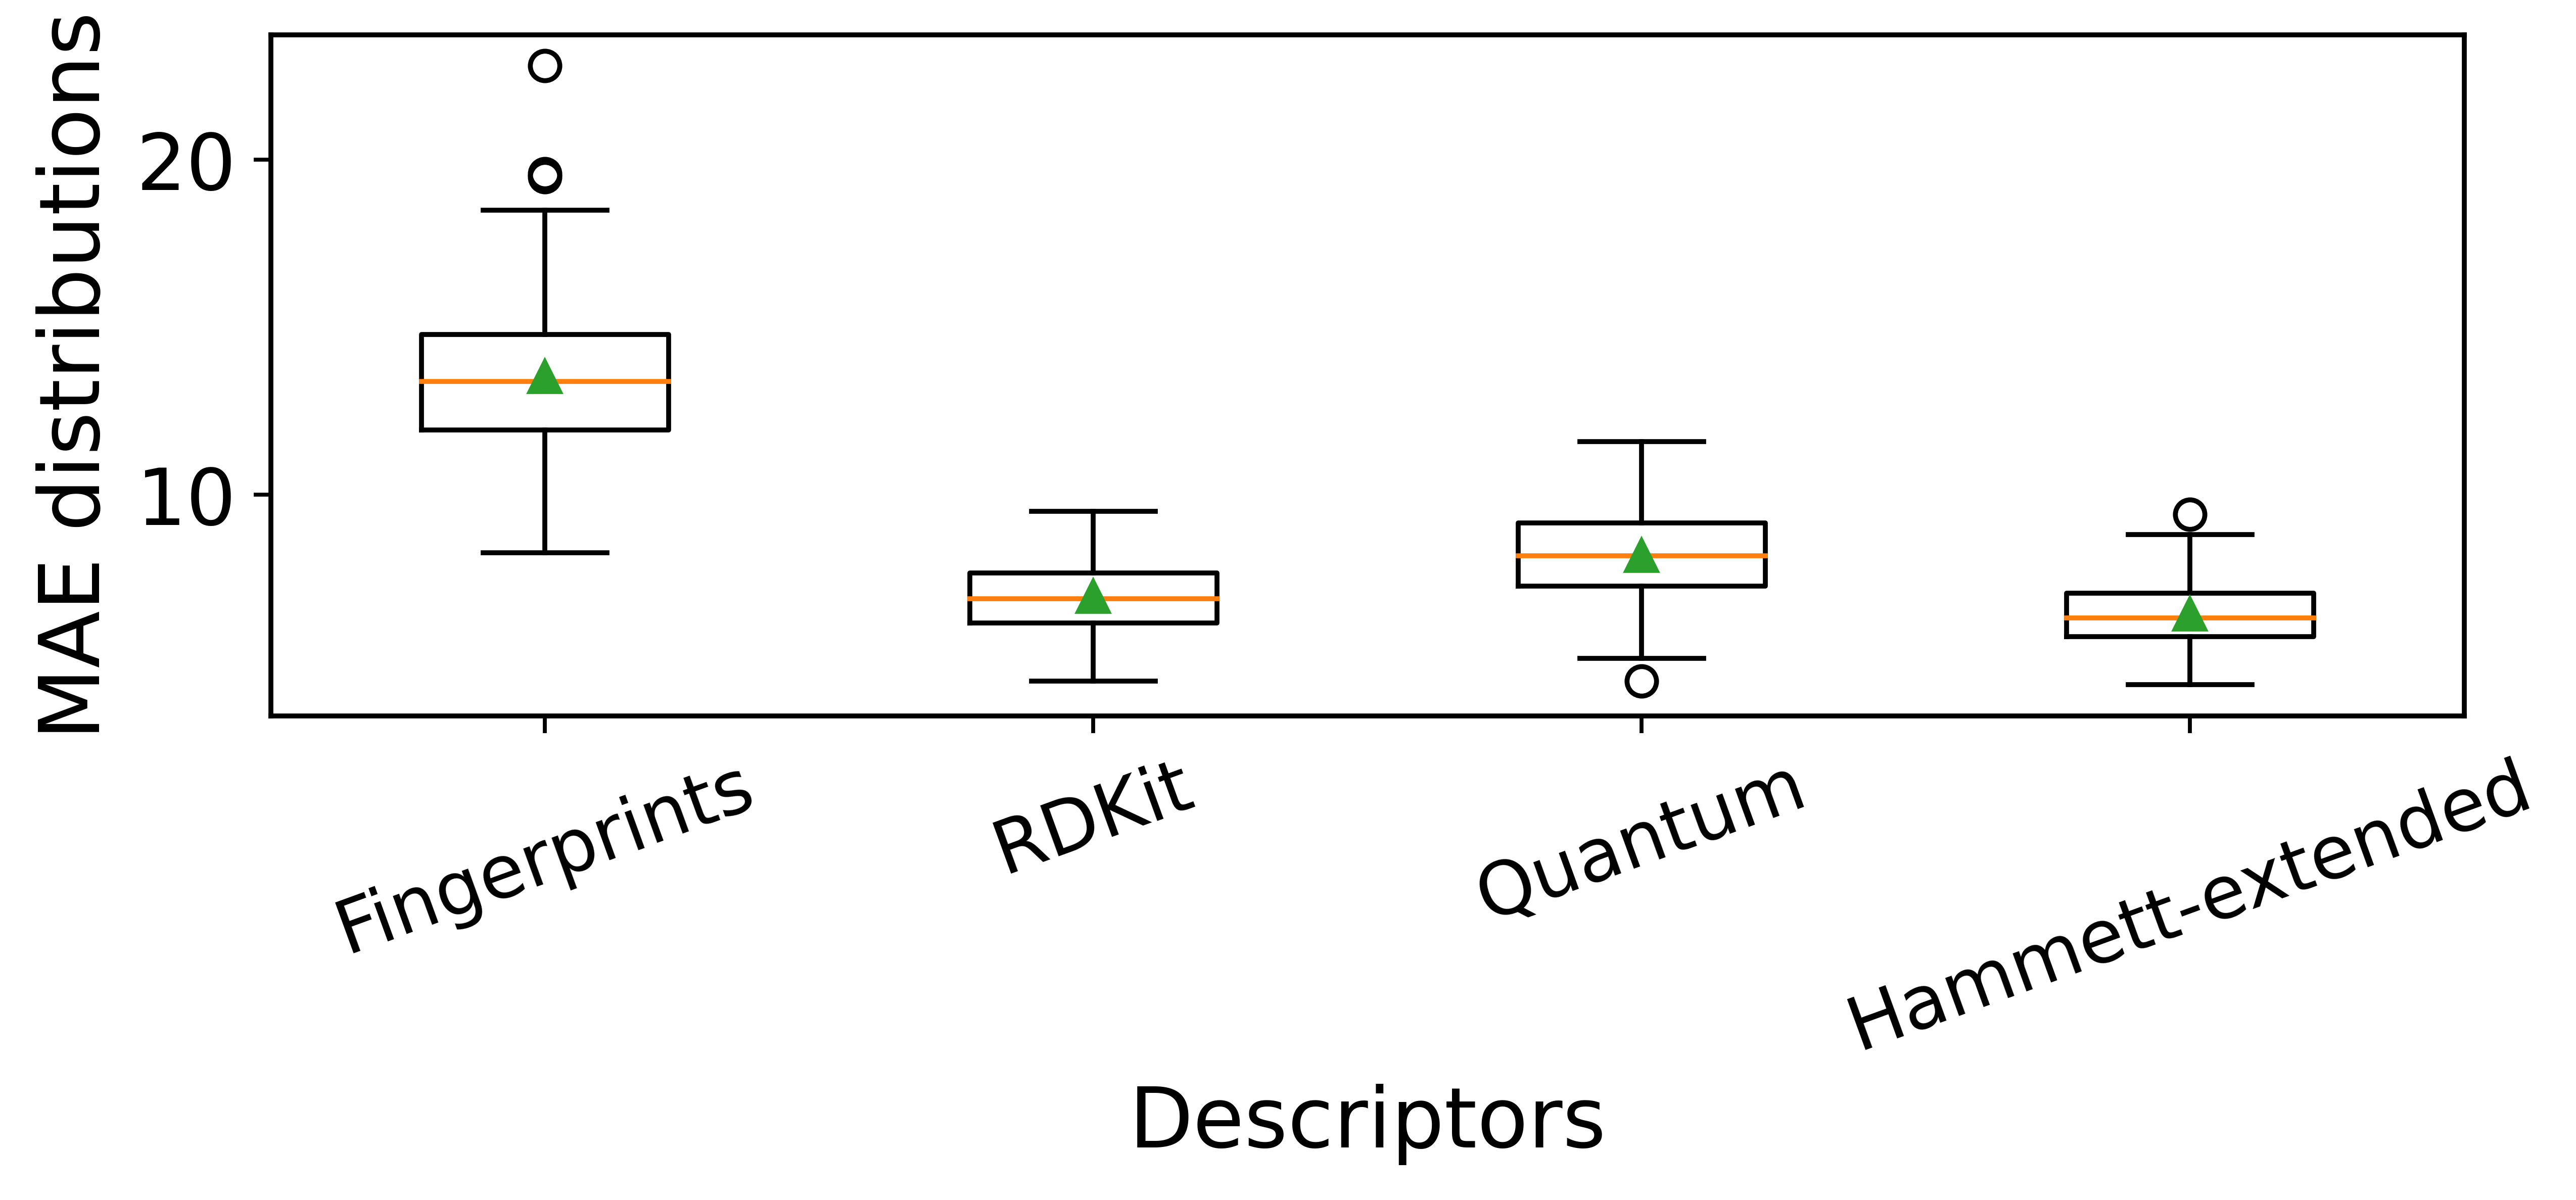

In [8]:
## 3rd graph 

fig,ax3 = plt.subplots(figsize=(8, 2.5))

df=pd.read_csv('article/tables/MAEs_Ridge_descriptors.csv').set_index('Descriptors')
descriptors=df.index
MAEs=[]
for desc in descriptors:
    MAEs.append(df.loc[desc])



ax3.boxplot(MAEs, labels=descriptors, showmeans=True, vert = True)


ax3.set_xlabel('Descriptors')
ax3.set_ylabel('MAE distributions')

plt.xticks(rotation=20, fontsize = 15)



fig.savefig('figures/poster/boxplot_descriptors.svg', format = 'svg', transparent= True, bbox_inches='tight')